<a href="https://colab.research.google.com/github/lilythomson13/finalproject/blob/main/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 3001 Final Project Results
### Alysha Akhtar & Lily Thomson

## Import dependencies and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
import random
import warnings

In [4]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv')

<ipython-input-4-902b012e865a>:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('METABRIC_RNA_Mutation.csv')


In [5]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1,Positve,...,0,0,0,0,0,0,0,0,0,0


## Set predictor and response variables for simple model

In [6]:
df = df.iloc[:, np.r_[1, 10, 13, 20, 23, 25, 28, 31:520]]

df = df.dropna()
df.loc[:, ['overall_survival_months', 'age_at_diagnosis', 'tumor_size', 'mutation_count']] = \
    df[['overall_survival_months', 'age_at_diagnosis', 'tumor_size', 'mutation_count']].apply(zscore)

y = df['overall_survival_months']

X_num = df.drop(columns=['er_status', 'pr_status', 'her2_status', 'overall_survival_months'])

X_dummies_er = pd.get_dummies(df['er_status'], dtype = 'int').rename(columns=lambda x: f'ER_{x}')
X_dummies_pr = pd.get_dummies(df['pr_status'], dtype = 'int').rename(columns=lambda x: f'PR_{x}')
X_dummies_her2 = pd.get_dummies(df['her2_status'], dtype = 'int').rename(columns=lambda x: f'HER2_{x}')
X = pd.concat([X_num, X_dummies_er, X_dummies_pr, X_dummies_her2], axis = 1)

In [7]:
y.head()

,overall_survival_months
1,-0.534836
2,0.503225
3,0.519418
4,-1.102881
5,-1.543575


In [8]:
X.head()

,age_at_diagnosis,mutation_count,tumor_size,brca1,brca2,palb2,pten,tp53,atm,cdh1,...,tulp4,ugt2b15,ugt2b17,ugt2b7,ER_Negative,ER_Positive,PR_Negative,PR_Positive,HER2_Negative,HER2_Positive
1,-1.379202,-0.994757,-1.073910,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,...,-0.9538,-0.2264,0.5398,-0.8920,0,1,0,1,1,0
2,-0.941783,-0.994757,-0.744699,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,...,-1.5538,1.3701,-0.1078,0.3655,0,1,0,1,1,0
3,-1.033425,-1.266216,-0.086277,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,...,-0.9924,-0.3154,0.2320,-0.4828,0,1,0,1,1,0
4,1.222211,-0.994757,0.901355,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,...,0.0427,5.0048,3.8476,1.3223,0,1,0,1,1,0
5,1.360830,-0.451840,0.308776,-0.4341,0.6931,0.6909,1.0840,-1.9371,0.9252,1.1520,...,-0.3021,0.9357,-0.4217,0.5340,0,1,0,1,1,0


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

In [10]:
X_train

,age_at_diagnosis,mutation_count,tumor_size,brca1,brca2,palb2,pten,tp53,atm,cdh1,...,tulp4,ugt2b15,ugt2b17,ugt2b7,ER_Negative,ER_Positive,PR_Negative,PR_Positive,HER2_Negative,HER2_Positive
328,-0.287964,-1.266216,-0.744699,-0.8980,-0.6789,-0.4020,-0.7048,-0.0022,-0.0720,0.4888,...,-1.7231,-0.2885,-0.3650,0.6813,0,1,0,1,1,0
994,0.814055,0.362535,0.901355,1.6078,0.9789,0.7595,-0.3186,1.5086,-0.0895,-0.1384,...,0.1752,1.0856,2.6932,0.5269,0,1,1,0,1,0
327,-0.271792,-1.266216,0.374618,-0.2357,-0.4845,-0.7699,-0.1456,1.5682,-1.2057,0.6431,...,0.3051,1.3945,-0.2338,1.9492,0,1,0,1,1,0
1488,0.311177,-0.723299,-0.415488,1.6729,0.0020,1.7741,-1.8489,0.5095,0.8885,-0.0450,...,0.3091,-0.6816,-0.3143,-0.9733,0,1,0,1,1,0
925,-0.856301,0.633994,1.230566,-0.3361,0.6936,0.7544,1.0900,-1.1583,0.3075,0.4725,...,-0.7090,-0.5864,-0.0671,-0.4158,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1.870639,0.362535,-0.283804,-0.5249,-1.8070,-0.3882,-0.6809,-0.0197,-0.6728,-2.4652,...,1.0745,-0.2219,-0.0188,-0.7405,0,1,1,0,1,0
386,0.053192,0.905452,-0.415488,-0.4089,-0.0268,1.3343,0.5266,1.5607,0.8584,-0.2269,...,0.3338,-0.2116,0.3272,-0.6414,0,1,0,1,1,0
92,1.912995,-0.723299,1.164724,-0.6247,0.9146,-0.0536,-0.0933,0.0326,-1.7125,-1.0493,...,-0.4592,-0.5628,-0.2193,2.5006,0,1,0,1,1,0
840,0.931881,0.091077,2.349884,-0.5928,0.9728,-1.4825,0.8788,-0.4346,1.8064,-0.1632,...,-0.3049,-0.5084,-0.5754,-0.8713,0,1,1,0,1,0


## Cross Validation to select number of components

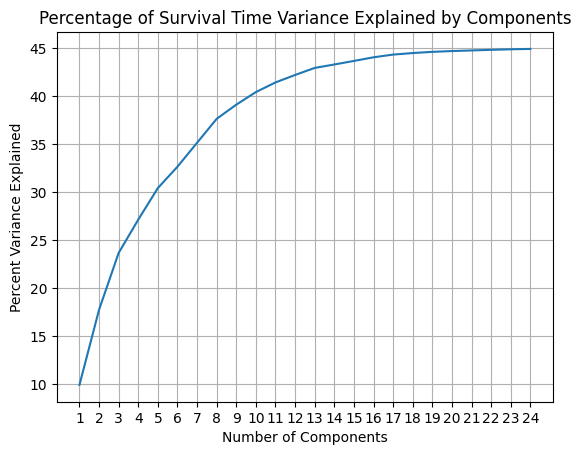

In [11]:
# To measure percent variance explained, run cross validation from 1 to 25 components
perc_var = []
x = range(1,25)
for i in np.arange(1, 25):
    pls = PLSRegression(n_components=i)
    pls.fit(X_train, y_train)
    y_fit = pls.predict(X_train)
    SSres = 0
    for i in range(1471):
        SSres += (y_train.iloc[i] - y_fit[i])**2
    SStot = 0
    for i in range(1471):
        SStot += (y_train.iloc[i] - np.mean(y_train.iloc[:]))**2
    perc_var.append(100*(1 - (SSres / SStot)))

plt.plot(x, perc_var)
plt.xticks(x)
plt.grid()
plt.title("Percentage of Survival Time Variance Explained by Components")
plt.xlabel("Number of Components")
plt.ylabel("Percent Variance Explained")
plt.show()

In [12]:
table = pd.DataFrame({'num_comp': x, 'Variation explained': perc_var})

print(table)

    num_comp  Variation explained
0          1             9.947103
1          2            17.767537
2          3            23.683373
3          4            27.146520
4          5            30.430387
5          6            32.652478
6          7            35.144121
7          8            37.632949
8          9            39.107178
9         10            40.416770
10        11            41.420307
11        12            42.195287
12        13            42.929786
13        14            43.286021
14        15            43.656274
15        16            44.034894
16        17            44.315812
17        18            44.477963
18        19            44.600552
19        20            44.684063
20        21            44.747722
21        22            44.812071
22        23            44.866678
23        24            44.905955


13 components should be used: this is where variance explained starts leveling off

In [13]:
pls = PLSRegression(n_components=13)
pls.fit(X_train, y_train)

PLSRegression(n_components=13)

## VIP Scores

In [33]:
# From https://www.researchgate.net/ online forum

def calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([(w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

vips = calculate_vips(pls)

<ipython-input-33-2acb3e37e1c2>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)


In [34]:
VIP = pd.DataFrame(index= X_train.columns)
VIP['VIP Score'] = None

for i in range(len(vips)):
    VIP.iloc[i,0] = vips[i]
VIP

,VIP Score
age_at_diagnosis,2.54055
mutation_count,1.12889
tumor_size,2.310454
brca1,0.69249
brca2,0.710763
...,...
ER_Positive,1.23248
PR_Negative,1.251016
PR_Positive,1.251016
HER2_Negative,1.411421


In [35]:
VIP_desc = VIP.reset_index().sort_values(by=['VIP Score'], ascending = False).set_index('index')
print(VIP_desc.head(10))

                 VIP Score
index                     
age_at_diagnosis   2.54055
tumor_size        2.310454
pdpk1             1.753507
sf3b1             1.645189
hsd3b7            1.555044
acvr1b            1.532486
ep300             1.532028
zfp36l1           1.529072
gsk3b              1.52183
taf1              1.501276


In [37]:
selected_variables = VIP[VIP['VIP Score'] > 1]
selected_variables = selected_variables.sort_values(by='VIP Score', ascending=False)
print(selected_variables)

selected_columns = selected_variables.index.tolist()
X_train_reduced = X_train[selected_columns]

                 VIP Score
age_at_diagnosis   2.54055
tumor_size        2.310454
pdpk1             1.753507
sf3b1             1.645189
hsd3b7            1.555044
...                    ...
rps6kb2           1.009579
ldlrap1           1.008945
l1cam             1.005954
tubb4b            1.001581
setd2                  1.0

[211 rows x 1 columns]


In [38]:
# Retrain PLSR with selected variables
pls_reduced = PLSRegression(n_components=13)
pls_reduced.fit(X_train_reduced, y_train)

PLSRegression(n_components=13)

In [39]:
# Predict on test data (with matching selected variables)
X_test_reduced = X_test[selected_columns]
y_pred = pls_reduced.predict(X_test_reduced)

In [40]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2}, MSE: {mse}")

R²: 0.010412183657422691, MSE: 0.9707331837639046


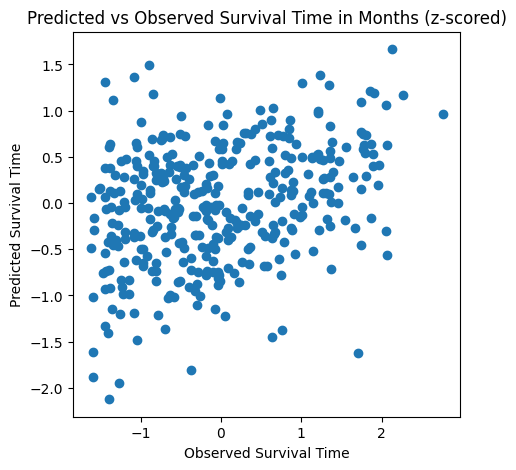

In [41]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Observed Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Predicted vs Observed Survival Time in Months (z-scored)")

plt.show()